In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
#import cartopy.crs as ccrs
import seaborn as sns
from src.regrid import *

In [47]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [48]:
!pwd

/home/garg/WeatherBench/nbs_probabilistic


In [49]:
args = load_args('../nn_configs/B/138-resnet_prec.yml')

In [50]:
args['test_years']

('2017', '2018')

In [52]:
# args['train_years']=['2017', '2017']
# args['valid_years']=['2018-01-01','2018-03-31']
# args['test_years']=['2018-04-01','2018-12-31']
args['model_save_dir'] ='/home/garg/data/WeatherBench/predictions/saved_models'
args['datadir']='/home/garg/data/WeatherBench/5.625deg'
args['pred_save_dir']: '/home/garg/data/WeatherBench/predictions'
#args

## Load Data

In [53]:
valid = xr.open_mfdataset(f'{args["datadir"]}/6hr_precipitation/*.nc',combine='by_coords')

In [54]:
valid

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17520)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    tp       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...

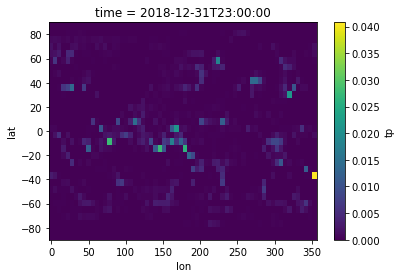

In [55]:
valid.tp.isel(time=-1).plot()

In [56]:
args['tp_log']

0.001

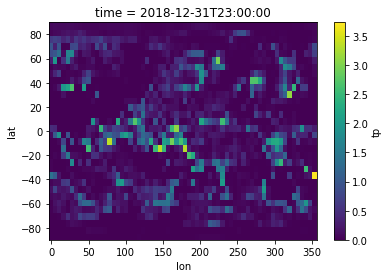

In [57]:
log_trans(valid.tp.isel(time=-1), args['tp_log']).plot()

# DataGenerator check

In [64]:
args['ext_mean'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')

dg_test=load_data(**args, only_test=True)

In [65]:
x,y=dg_test[0]
x.shape, y.shape

((32, 32, 64, 114), (32, 32, 64, 1))

In [66]:
#WRong. Not reading tp, toa

In [61]:
args["datadir"]

'/home/garg/data/WeatherBench/5.625deg'

In [34]:
ds_in = xr.open_mfdataset(f'{args["datadir"]}/6hr_precipitation/*.nc', combine='by_coords')

In [36]:
ds_out = ds_in.rolling(time=6, center=False, keep_attrs=True).sum()

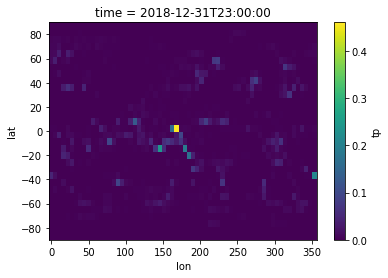

In [37]:
ds_out.tp.isel(time=-1).plot()

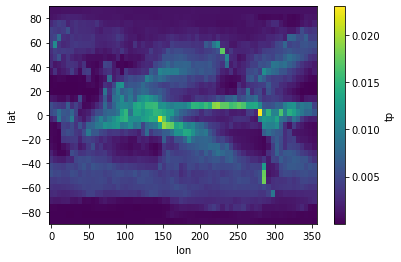

In [38]:
ds_out.tp.sel(time=slice('2017', '2017', )).mean('time').plot()

In [70]:
ds = xr.merge([xr.open_mfdataset(f'{args["datadir"]}/{var}/*.nc', combine='by_coords') for var in args['var_dict'].keys()])

In [73]:
ds_test = ds.sel(time=slice(*args["test_years"]))

In [74]:
ds_test

<xarray.Dataset>
Dimensions:    (lat: 32, level: 13, lon: 64, time: 17520)
Coordinates:
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * level      (level) int32 50 100 150 200 250 300 400 500 600 700 850 925 1000
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Data variables:
    z          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
    t          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
    u          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
    v          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
    q          (time, level, lat, lon) float32 dask.array<chunksize=(8760, 13, 32, 64), meta=np.ndarray>
    tisr       (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    tp         (time, lat, lon) float32 dask.array<chunksize=(8760, 32, 64), meta=np.ndarray>
    orography  (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    lsm        (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    slt        (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
    lat2d      (lat, lon) float64 dask.array<chunksize=(32, 64), meta=np.ndarray>
    lon2d      (lat, lon) float64 dask.array<chunksize=(32, 64), meta=np.ndarray>

In [83]:
args["data_subsample"]=6

In [84]:
dg_test = DataGenerator(
        ds_test, args["var_dict"], args["lead_time"], batch_size=args["batch_size"],
        data_subsample=args["data_subsample"],
        mean=args["ext_mean"] if args["ext_mean"] is not None else dg_train.mean,
        std=args["ext_std"] if args["ext_std"] is not None else dg_train.std,
        shuffle=False, output_vars=args["output_vars"], nt_in=args["nt_in"], dt_in=args["dt_in"],
        cont_time=args["cont_time"], multi_dt=args["multi_dt"],
        load=args["test_tfr_files"] is None,
        tfrecord_files=args["test_tfr_files"],
        tfr_num_parallel_calls=1,
        tfr_buffer_size=1,
        tfr_prefetch=None, y_roll=args["y_roll"], X_roll=args["X_roll"],
        tfr_repeat=False,
        min_lead_time=args["min_lead_time"], tp_log=args["tp_log"], tfr_out=args["tfr_out"],
        tfr_out_idxs=args["tfr_out_idxs"], predict_difference=args["predict_difference"],
        is_categorical=args["is_categorical"], bin_min=args["bin_min"], bin_max=args["bin_max"], num_bins=args["num_bins"],
    )

In [85]:
x,y=dg_test[0]
x.shape, y.shape

((32, 32, 64, 114), (32, 32, 64, 1))

## Evaluation

In [21]:
model = keras.models.load_model(
    f'{args["model_save_dir"]}/{args["exp_id"]}.h5',
    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'ChannelReLU2D': ChannelReLU2D, 
                   'lat_mse': tf.keras.losses.mse}
)
#RECHECK LOSS fn.!

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 120) 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  752768      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         leaky_re_lu[0][0]                
______________________________________________________________________________________________

In [24]:
preds=model.predict(dg_test)

InvalidArgumentError:  input depth must be evenly divisible by filter depth: 114 vs 120
	 [[node model/periodic_conv2d/conv2d_80/Conv2D (defined at /home/garg/WeatherBench/nbs_probabilistic/src/networks.py:74) ]] [Op:__inference_predict_function_23000]

Errors may have originated from an input operation.
Input Source operations connected to node model/periodic_conv2d/conv2d_80/Conv2D:
 model/periodic_conv2d/periodic_padding2d_80/Pad (defined at /home/garg/WeatherBench/nbs_probabilistic/src/networks.py:25)

Function call stack:
predict_function


In [28]:
dg_test.output_idxs

[36]

In [ ]:
tp_idx = list(preds.level_names).index('tp')
        preds.values[..., tp_idx] = log_retrans(preds.values[..., tp_idx], dg.mean.tp_log)

In [97]:
valid.sel(time='2017-01-04T12').isel(lat=20, lon=0).values()

ValuesView(<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lat      float64 25.31
    lon      float64 0.0
    time     datetime64[ns] 2017-01-04T12:00:00
Data variables:
    tp       float32 dask.array<chunksize=(), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...)

In [89]:
valdi_shifted=valid.shift(time=72)

In [91]:
valdi_shifted.sel(time='2017-01-04T12')

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    time     datetime64[ns] 2017-01-04T12:00:00
Data variables:
    tp       (lat, lon) float32 dask.array<chunksize=(32, 64), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2020-01-01 16:44:41 GMT by grib_to_netcdf-2.15.0: /opt/ecmw...